# Deep Learning Models

We compare several deep learning models to test their performance on EEG data

## 1. Simple CNN

### 1.1 Data Preparation

In [1]:
# Load one subject's data
import numpy as np
import os
from pathlib import Path

DATA = Path("../data/raw")
subject = 'S001'
X = np.load(os.path.join(DATA, subject + '_X.npy'))
y = np.load(os.path.join(DATA, subject + '_y.npy'))
X.shape, y.shape

((655, 7501), (655,))

In [10]:
# Combine data from all subjects

subjects = ["S001", "S002", "S003"]

Xs, ys, groups = [], [], []
for i, sid in enumerate(subjects):
    X = np.load(os.path.join(DATA, sid + '_X.npy'))  # (N, 7501)
    y = np.load(os.path.join(DATA, sid + '_y.npy'))  # (N,)
    Xs.append(X)
    ys.append(y)
    groups.append(np.full(len(y), i))  # subject id per epoch

X_all = np.concatenate(Xs, axis=0)
y_all = np.concatenate(ys, axis=0)
g_all = np.concatenate(groups, axis=0)

print(X_all.shape, y_all.shape, g_all.shape)

(2542, 7501) (2542,) (2542,)


In [11]:
test_subject = 2  # (2 = S003)
train_idx = (g_all != test_subject) # boolean mask
test_idx  = (g_all == test_subject)

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

X_train = X_train[:, None, :]  # (N_train, 1, 7501) (add channel dim)
X_test  = X_test[:, None, :] # (N_test, 1, 7501) (add channel dim)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1719, 1, 7501), (1719,), (823, 1, 7501), (823,))

### 1.2 Data Preprocessing

We normalize the EEG data per epoch to ensure consistent scaling across samples.

In [14]:
mean = X_train.mean()
std  = X_train.std() + 1e-8 # avoid div by zero

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

print("train mean/std:", X_train.mean(), X_train.std())
print("test  mean/std:", X_test.mean(), X_test.std())

y_train[0]


train mean/std: 1.4107014961866683e-19 0.9999999900000001
test  mean/std: -0.00019945469165636413 0.46124000024736217


np.str_('S')

In [15]:
# Encode y-train and y-test

train_classes = sorted(set(y_train))
label2id = {lbl: i for i, lbl in enumerate(train_classes)}
id2label = {i: lbl for lbl, i in label2id.items()}

y_train_id = np.array([label2id[lbl] for lbl in y_train], dtype=np.int64)
y_test_id = np.array([label2id[lbl] for lbl in y_test], dtype=np.int64)

print("label2id:", label2id)
print("y_train_id unique:", np.unique(y_train_id))
print("y_test_id unique :", np.unique(y_test_id))

label2id: {np.str_('A'): 0, np.str_('K'): 1, np.str_('MS'): 2, np.str_('REM'): 3, np.str_('S'): 4, np.str_('Soff'): 5, np.str_('Son'): 6}
y_train_id unique: [0 1 2 3 4 5 6]
y_test_id unique : [0 1 2 3 4 5 6]


In [16]:
# Convert to torch tensors

import torch
from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train_id, dtype=torch.long)

Xte = torch.tensor(X_test, dtype=torch.float32)
yte = torch.tensor(y_test_id, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=64, shuffle=False)



In [18]:
# Class weights to handle class imbalance

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

classes = np.arange(len(label2id))
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_id)
class_weights = torch.tensor(weights, dtype=torch.float32)
print({id2label[i]: float(class_weights[i]) for i in range(len(classes))})



{np.str_('A'): 7.016326427459717, np.str_('K'): 0.576458752155304, np.str_('MS'): 35.081634521484375, np.str_('REM'): 0.6154672503471375, np.str_('S'): 0.31686636805534363, np.str_('Soff'): 8.770408630371094, np.str_('Son'): 5.011662006378174}


In [21]:
# Balanced sampling

import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np

# per-sample weights = weight of its class
sample_weights = np.array([class_weights[int(c)] for c in y_train_id], dtype=np.float32)
n_classes = len(label2id)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_balanced = DataLoader(
    TensorDataset(Xtr, ytr),
    batch_size=64,
    sampler=sampler
)


### 1.3 Model 

In [22]:
import torch.nn as nn

class TinyEEGCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),

            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        return self.net(x)


### 1.4 Training

In [23]:
import torch
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyEEGCNN(n_classes=n_classes).to(device)

epochs = 10

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / n, correct / n

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")


c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 01 | train loss 1.8174 acc 0.297 | test loss 1.5945 acc 0.311


Epoch 02 | train loss 1.6804 acc 0.441 | test loss 1.7796 acc 0.310


Epoch 03 | train loss 1.5816 acc 0.365 | test loss 1.9992 acc 0.294


Epoch 04 | train loss 1.5114 acc 0.493 | test loss 1.8376 acc 0.279


Epoch 05 | train loss 1.4348 acc 0.492 | test loss 1.7219 acc 0.289


Epoch 06 | train loss 1.4255 acc 0.534 | test loss 2.6080 acc 0.295


Epoch 07 | train loss 1.3370 acc 0.552 | test loss 1.6434 acc 0.327


Epoch 08 | train loss 1.3743 acc 0.580 | test loss 1.6324 acc 0.207


Epoch 09 | train loss 1.3183 acc 0.574 | test loss 1.4389 acc 0.391


Epoch 10 | train loss 1.2827 acc 0.576 | test loss 1.5852 acc 0.329


### 1.5 Evaluation

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).cpu().numpy()
        preds = logits.argmax(axis=1)
        all_preds.append(preds)
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

# readable per-class stats
target_names = [id2label[i] for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))



Macro F1: 0.1527399748803789
              precision    recall  f1-score   support

           A      0.000     0.000     0.000        20
           K      0.667     0.011     0.021       378
          MS      0.024     1.000     0.047         2
         REM      0.453     0.867     0.595       256
           S      0.242     0.317     0.275       123
        Soff      0.045     0.143     0.069        14
         Son      0.059     0.067     0.062        30

    accuracy                          0.329       823
   macro avg      0.213     0.343     0.153       823
weighted avg      0.486     0.329     0.239       823



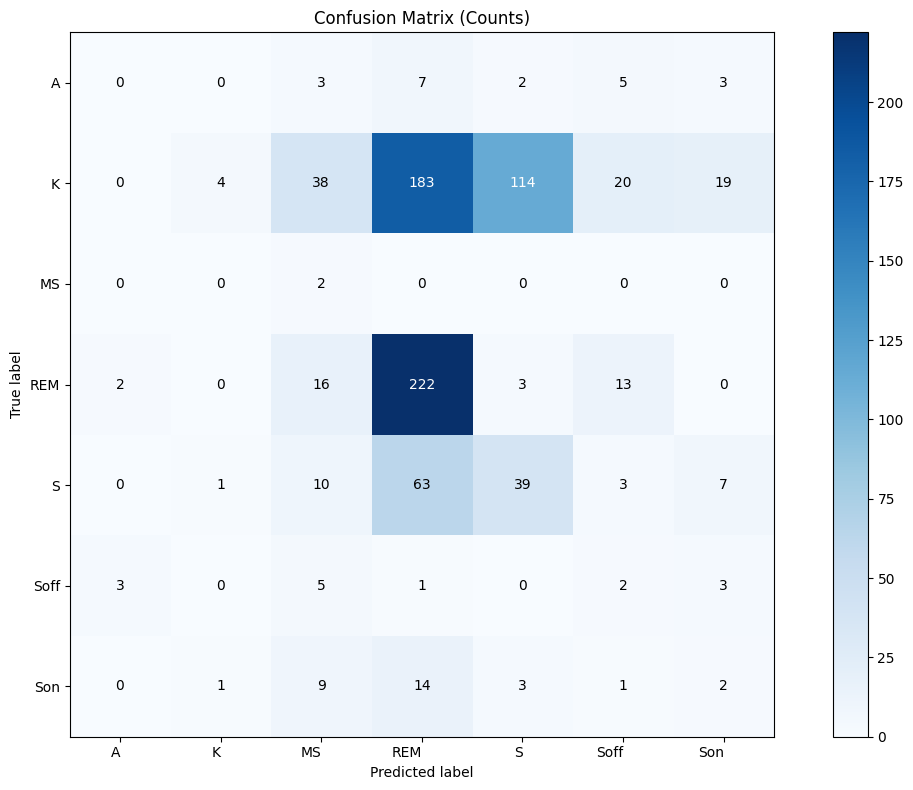

In [29]:
# PLot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()

plt.xticks(np.arange(n_classes), target_names, ha='right')
plt.yticks(np.arange(n_classes), target_names)

# annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() * 0.5 else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Counts)')
plt.tight_layout()
plt.show()


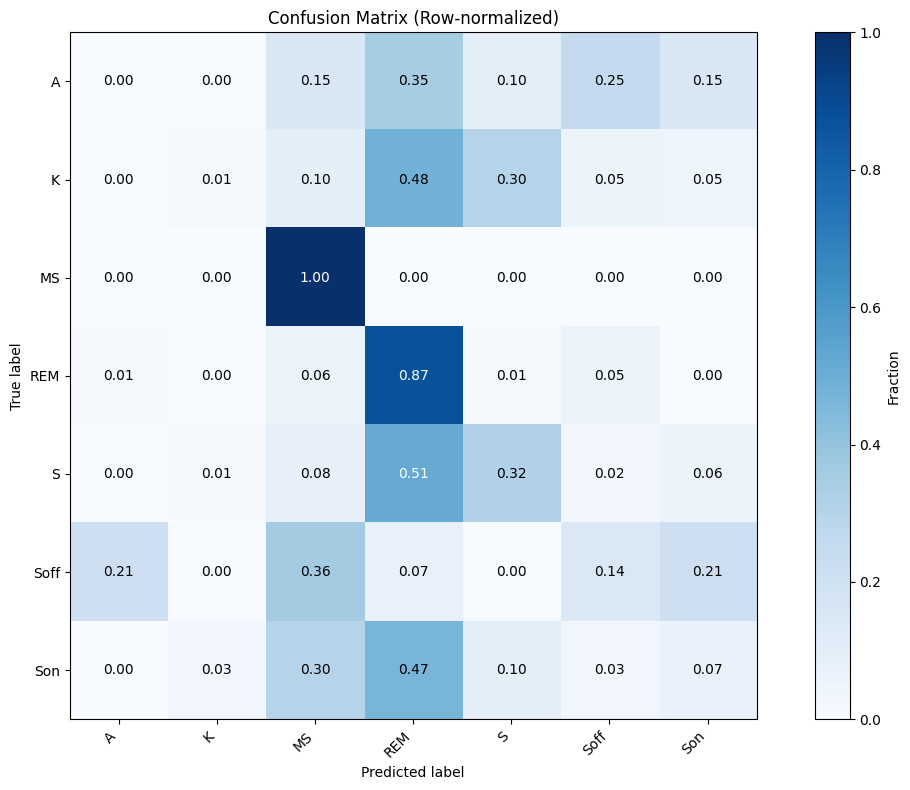

In [30]:
# Normalized confusion matrix

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 8))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(label="Fraction")

plt.xticks(np.arange(n_classes), target_names, rotation=45, ha='right')
plt.yticks(np.arange(n_classes), target_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        plt.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color="white" if val > 0.5 else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Row-normalized)')
plt.tight_layout()
plt.show()
